In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm import tqdm
from omegaconf import OmegaConf
import umap
from models import JointLatentDiffusionMultilabel
from datasets import ChestXRay_nih_bbox
import torchvision as tv
from ldm.util import default
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from einops import rearrange, repeat
from ldm.models.diffusion.ddim import DDIMSampler


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-16 11:36:31.373654: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 11:36:31.376691: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 11:36:31.432814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appr

In [2]:
config = OmegaConf.load("logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/configs/config.yaml")
config.model.params["ckpt_path"] = f"logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/checkpoints/last.ckpt"

# config = OmegaConf.load("logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/checkpoints/last.ckpt"
model = JointLatentDiffusionMultilabel(**config.model.get("params", dict()))

model.to(device)
model.eval()


JointLatentDiffusionMultilabel: Running in eps-prediction mode
DiffusionWrapper has 402.65 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/logs/compvis32x32x4_all_randomresizedcrop_Autoencoder_2024-01-17T13-15-27/checkpoints/epoch=000025.ckpt
Training JointLatentDiffusionMultilabel as an unconditional model.
Keeping EMAs of 312.
Restored from logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/checkpoints/last.ckpt with 0 missing and 0 unexpected keys
WARNING AUROC HARDCODEDDDD to 14 classes


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


JointLatentDiffusionMultilabel(
  (model): DiffusionWrapper(
    (diffusion_model): AdjustedUNet(
      (time_embed): Sequential(
        (0): Linear(in_features=320, out_features=1280, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=1280, out_features=320, bias=True)
            )
            (out_layers): Sequen

In [3]:
model.sample_grad_scale=50

In [4]:
def embed_imgs(model, data_loader, max_samples=1):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list, bbox_list, label_list = [], [], [], []

    for imgs, bbox, label in tqdm(data_loader):
        if len(imgs.shape) == 3:
            imgs = imgs[..., None]
        imgs = rearrange(imgs, 'b h w c -> b c h w')

        with torch.no_grad():
            encoder_posterior = model.encode_first_stage(imgs.cuda())
            latent = model.get_first_stage_encoding(encoder_posterior).detach()
            img_list.append(imgs.cpu())
            embed_list.append(latent.cpu())
            bbox_list.append(bbox)
            label_list.append(label)
        if max_samples is not None and len(img_list) > max_samples:
            break
    return (img_list, embed_list, bbox_list, label_list)

In [5]:
dataset = ChestXRay_nih_bbox(pick_class="Cardiomegaly")
dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

BBOX READ AS INT FIX IT


In [6]:
ret = embed_imgs(model, dl)

  0%|          | 0/146 [00:00<?, ?it/s]

  1%|          | 1/146 [00:00<00:40,  3.61it/s]


In [7]:
ret[1][0].shape

torch.Size([1, 4, 32, 32])

In [8]:
for img_original, z, bbox in zip(ret[0], ret[1], ret[2]):
    num_timesteps = 1000
    n_row = 12 #number of images to show
    n_row = min(z.shape[0], n_row)
    z = z.to(model.device)

    # get diffusion row
    diffusion_row = list()
    z_start = z[:n_row]
    ts = 50
    t = repeat(torch.tensor([ts]), '1 -> b', b=n_row)
    t = t.to(model.device).long()
    noise = torch.randn_like(z_start)
    z_noisy = model.q_sample(x_start=z_start, t=t, noise=noise)
    break
z_noisy.shape, img_original.shape, bbox.shape

(torch.Size([1, 4, 32, 32]), torch.Size([1, 1, 256, 256]), torch.Size([1, 4]))

DDPM

In [9]:
shape = z_noisy.shape
samples = model.p_sample_loop(cond=None, shape = shape, original_img = img_original, return_intermediates=False, x_T=z_noisy, start_T=50)
x_samples = model.decode_first_stage(samples)

Sampling t:   0%|          | 0/50 [00:00<?, ?it/s]

[(tensor(0.4873, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4417, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5281, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5189, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5382, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5239, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5538, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5090, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5124, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5198, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4286, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5245, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.5007, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5718, devi

Sampling t:   6%|▌         | 3/50 [00:00<00:10,  4.58it/s]

[(tensor(0.4872, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4423, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5282, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5191, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5388, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5243, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5538, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5093, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5129, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5201, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4289, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5247, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.5006, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5719, devi

Sampling t:  10%|█         | 5/50 [00:01<00:06,  6.67it/s]

[(tensor(0.4871, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4419, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5276, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5183, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5395, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5229, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5527, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5087, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5127, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5195, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4290, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5235, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4994, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5710, devi

Sampling t:  14%|█▍        | 7/50 [00:01<00:05,  7.93it/s]

[(tensor(0.4869, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4413, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5270, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5180, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5394, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5217, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5512, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5079, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5125, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5189, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4290, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5226, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4985, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5701, devi

Sampling t:  18%|█▊        | 9/50 [00:01<00:04,  8.85it/s]

[(tensor(0.4870, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4421, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5270, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5172, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5402, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5220, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5506, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5078, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5129, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5192, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4291, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5232, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4981, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5703, devi

Sampling t:  24%|██▍       | 12/50 [00:01<00:04,  9.31it/s]

[(tensor(0.4874, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4421, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5266, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5169, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5403, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5227, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5502, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5077, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5135, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5200, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4302, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5233, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4984, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5704, devi

Sampling t:  28%|██▊       | 14/50 [00:01<00:03,  9.36it/s]

[(tensor(0.4874, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4420, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5272, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5168, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5403, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5221, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5497, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5073, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5139, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5193, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4300, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5223, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4977, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5703, devi

Sampling t:  32%|███▏      | 16/50 [00:02<00:03,  9.42it/s]

[(tensor(0.4875, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4425, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5270, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5164, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5410, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5215, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5487, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5077, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5137, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5188, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4295, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5218, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4964, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5702, devi

Sampling t:  36%|███▌      | 18/50 [00:02<00:03,  9.46it/s]

[(tensor(0.4877, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4431, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5268, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5156, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5414, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5208, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5478, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5074, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5139, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5179, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4297, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5215, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4954, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5700, devi

Sampling t:  40%|████      | 20/50 [00:02<00:03,  9.49it/s]

[(tensor(0.4882, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4433, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5262, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5153, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5412, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5203, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5465, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5069, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5137, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5175, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4301, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5212, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4947, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5694, devi

Sampling t:  44%|████▍     | 22/50 [00:02<00:02,  9.52it/s]

[(tensor(0.4880, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4434, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5261, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5154, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5410, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5208, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5463, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5070, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5133, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5174, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4306, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5211, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4952, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5695, devi

Sampling t:  48%|████▊     | 24/50 [00:03<00:02,  9.59it/s]

[(tensor(0.4884, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4434, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5253, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5154, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5415, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5202, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5454, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5066, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5132, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5168, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4302, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5203, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4950, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5690, devi

Sampling t:  52%|█████▏    | 26/50 [00:03<00:02,  9.53it/s]

[(tensor(0.4879, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4434, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5246, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5148, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5421, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5192, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5446, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5059, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5134, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5166, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4299, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5193, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4940, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5686, devi

Sampling t:  56%|█████▌    | 28/50 [00:03<00:02,  9.56it/s]

[(tensor(0.4882, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4437, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5240, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5143, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5424, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5189, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5448, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5063, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5130, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5168, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4302, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5196, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4939, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5691, devi

Sampling t:  60%|██████    | 30/50 [00:03<00:02,  9.77it/s]

[(tensor(0.4882, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4432, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5243, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5136, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5424, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5183, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5445, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5059, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5126, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5163, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4310, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5198, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4937, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5695, devi

Sampling t:  64%|██████▍   | 32/50 [00:03<00:01,  9.77it/s]

[(tensor(0.4880, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4427, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5241, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5116, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5436, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5154, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5415, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5031, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5122, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5146, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4297, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5180, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4920, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5676, devi

Sampling t:  72%|███████▏  | 36/50 [00:04<00:01,  9.85it/s]

[(tensor(0.4886, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4424, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5235, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5107, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5437, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5142, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5404, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.5020, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5112, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5137, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4301, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5169, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4906, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5673, devi

Sampling t:  76%|███████▌  | 38/50 [00:04<00:01,  9.80it/s]

[(tensor(0.4880, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4415, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5221, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5088, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5434, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5119, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5384, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.4997, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5111, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5114, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4295, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5155, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4893, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5657, devi

Sampling t:  80%|████████  | 40/50 [00:04<00:01,  9.81it/s]

[(tensor(0.4878, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4410, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5211, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5073, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5435, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5108, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5378, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.4984, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5106, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5108, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4293, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5143, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4881, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5656, devi

Sampling t:  84%|████████▍ | 42/50 [00:04<00:00,  9.78it/s]

[(tensor(0.4877, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4407, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5194, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5057, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5435, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5100, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5365, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.4979, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5103, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5101, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4291, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5127, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4865, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5643, devi

Sampling t:  88%|████████▊ | 44/50 [00:05<00:00,  9.80it/s]

[(tensor(0.4877, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4386, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5171, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.5017, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5438, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5051, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5309, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.4933, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5088, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5058, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4268, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5087, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4828, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5594, devi

Sampling t:  90%|█████████ | 45/50 [00:05<00:00,  9.80it/s]

[(tensor(0.4873, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4379, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5150, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.4988, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5435, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.5020, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5273, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.4900, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5077, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.5036, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4258, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.5067, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4802, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5561, devi

Sampling t:  96%|█████████▌| 48/50 [00:05<00:00,  9.96it/s]

[(tensor(0.4836, device='cuda:0', grad_fn=<UnbindBackward0>), 'Atelectasis'), (tensor(0.4302, device='cuda:0', grad_fn=<UnbindBackward0>), 'Cardiomegaly'), (tensor(0.5049, device='cuda:0', grad_fn=<UnbindBackward0>), 'Consolidation'), (tensor(0.4858, device='cuda:0', grad_fn=<UnbindBackward0>), 'Edema'), (tensor(0.5449, device='cuda:0', grad_fn=<UnbindBackward0>), 'Effusion'), (tensor(0.4765, device='cuda:0', grad_fn=<UnbindBackward0>), 'Emphysema'), (tensor(0.5002, device='cuda:0', grad_fn=<UnbindBackward0>), 'Fibrosis'), (tensor(0.4674, device='cuda:0', grad_fn=<UnbindBackward0>), 'Hernia'), (tensor(0.5048, device='cuda:0', grad_fn=<UnbindBackward0>), 'Infiltration'), (tensor(0.4851, device='cuda:0', grad_fn=<UnbindBackward0>), 'Mass'), (tensor(0.4150, device='cuda:0', grad_fn=<UnbindBackward0>), 'Nodule'), (tensor(0.4857, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pleural_Thickening'), (tensor(0.4634, device='cuda:0', grad_fn=<UnbindBackward0>), 'Pneumonia'), (tensor(0.5327, devi

Sampling t: 100%|██████████| 50/50 [00:05<00:00,  8.83it/s]


In [10]:
x_samples.shape

torch.Size([1, 1, 256, 256])

PLOT IMGS

Text(0.5, 0.98, 'Cardiomegaly')

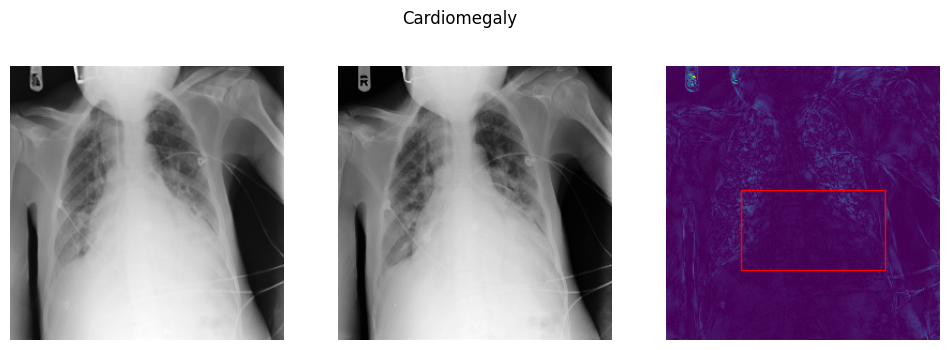

In [11]:
idx_from_batch = 0

fig, axes = plt.subplots(1, 3, figsize=(12, 4))


# Plot the images on the subplots
denoised_guided = x_samples.cpu()[idx_from_batch].permute(1,2,0)
img_ref = img_original.cpu()[idx_from_batch].permute(1,2,0)
diff = abs(denoised_guided - img_ref)

ax = 0
axes[ax].imshow(denoised_guided, cmap='gray')
axes[ax].axis('off')

ax +=1
axes[ax].imshow(img_ref, cmap='gray')
axes[ax].axis('off')

ax +=1


x, y, w, h = bbox[idx_from_batch][0], bbox[idx_from_batch][1],bbox[idx_from_batch][2], bbox[idx_from_batch][3]
# Scale the bounding box coordinates from 1024x1024 to 256x256
scaled_x = x * 0.25
scaled_y = y * 0.25
scaled_w = w * 0.25
scaled_h = h * 0.25

# Create a rectangle patch using the scaled coordinates
rect = patches.Rectangle((scaled_x, scaled_y), scaled_w, scaled_h, linewidth=1, edgecolor='r', facecolor='none')

# Add the rectangle patch to the plot
axes[ax].add_patch(rect)


axes[ax].imshow(diff)
axes[ax].axis('off')

fig.suptitle(ret[3][0][idx_from_batch])

